In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers 
from tensorflow.keras.utils import plot_model
import scipy.stats as stats
import os 
import h5py
import sys
import re

%matplotlib inline 

dataset = h5py.File('./../../../../../data/hongtao/variables_tt_re2.h5','r')

X_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'lep_pt', 'lep_eta', 'met_met', 'met_phi'] 
Y_keys = ['th_pt', 'th_eta','th_phi', 'tl_pt', 'tl_eta', 'tl_phi', 'wl_eta', 'wl_phi', 'wl_pt']
phi_keys = ['j1_phi', 'j2_phi', 'j3_phi','j4_phi','j5_phi','j6_phi', 'lep_phi', 'met_phi', 'th_phi', 'tl_phi', 'wl_phi']
eta_keys = ['j1_eta', 'j2_eta', 'j3_eta', 'j4_eta', 'j5_eta', 'j5_phi', 'j6_eta', 'lep_eta', 'th_eta', 'tl_eta', 'wl_eta']
pt_keys = ['j1_pt', 'j2_pt','j3_pt','j4_pt','j5_pt','j6_pt','lep_pt','th_pt', 'tl_pt', 'wl_pt']
m_keys = ['j1_m','j2_m', 'j3_m', 'j4_m', 'j5_m', 'j6_m', 'wl_m']
DL1r_keys = ['j1_DL1r','j2_DL1r','j3_DL1r','j4_DL1r','j5_DL1r','j6_DL1r']

Y_length = len(Y_keys)
X_length = len(X_keys)
crop0 =  100000 

In [10]:
import scale_variables

# How to scale each input/output
def get_methods(keys):
    types = {'pt':'boxcox', 'eta':'meanmax', 'phi':'linear_sincos', 'DL1r':'meanmax', 'm':'boxcox', 'met':'meanmax'}
    var_types = [key.split('_')[1] for key in keys]
    methods = [types[var] for var in var_types]
    return methods

X_methods = get_methods(X_keys)
Y_methods = get_methods(Y_keys)

Scaler = scale_variables.Scale_variables()
(X_total, X_maxmean), X_names = Scaler.scale_arrays(X_keys, X_methods, True)
(Y_total, Y_maxmean), Y_names = Scaler.scale_arrays(Y_keys, Y_methods, True)

error = Scaler.test_inverse(X_keys, X_methods, True)
print('Max scaling error: {}'.format(error))

Max scaling error: 1.1368683772161603e-12


In [11]:
# Create X and test array
split = int(np.floor(0.9*crop0))
shuffle = False

if shuffle:
    rng_state = np.random.get_state()
    np.random.shuffle(X_total)
    np.random.set_state(rng_state)
    np.random.shuffle(Y_total)

trainX, testX = X_total[0:split, :], X_total[split:,:]
trainY, testY = Y_total[0:split,:], Y_total[split:,:]

print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(90000, 44) (90000, 12)
(10000, 44) (10000, 12)


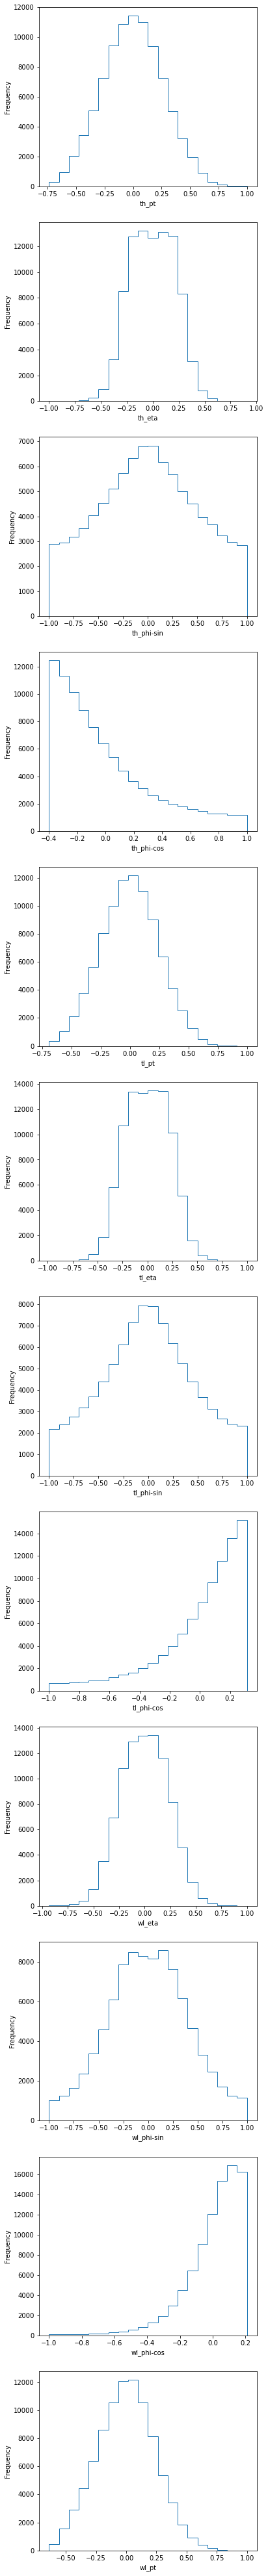

In [12]:
# Histograms of Y variables 
show = True

if show:
    plt.figure(figsize=(6,6*trainY.shape[1]))
    for i in range(0, trainY.shape[1]):
        plt.subplot(trainY.shape[1], 1, i+1)
        plt.hist(trainY[:,i], 20, histtype='step')
        plt.xlabel(Y_names[i])
        plt.ylabel('Frequency')

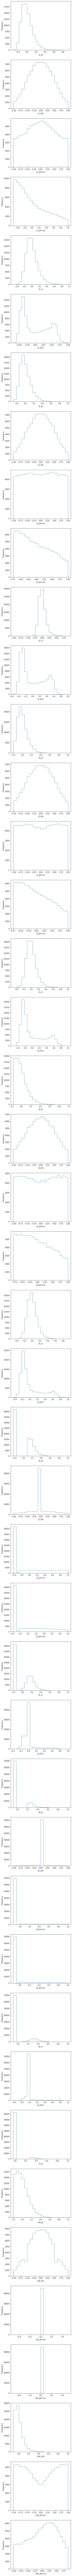

In [13]:
# Histograms of X variables 
show = True

if show:
    plt.figure(figsize=(6,6*trainX.shape[1]))
    for i in range(0, trainX.shape[1]):
        plt.subplot(trainX.shape[1], 1, i+1)
        plt.hist(trainX[:,i], 20, histtype='step')
        plt.xlabel(X_names[i])
        plt.ylabel('Frequency')

 

In [14]:
# Build model

# optimizer = keras.optimizers.RMSprop(learning_rate = 1e-5)
optimizer = keras.optimizers.Adam(learning_rate=1e-6)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


def build_model():
    model = keras.Sequential([
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001),
                     input_shape=[len(X_names)]),
        layers.Dense(256,  activation='relu'),
        layers.Dense(256,  activation='relu'),
        layers.Dense(256,  activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(len(Y_names),  activation='linear')
    ])
    
    model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    return model 

# def build_model():
#     model = keras.Sequential([
#         layers.Dense(6, activation='linear', 
#                      X_shape=[len(X_keys)])])
    
#     model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    
#     return model 
    

In [15]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               23040     
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_12 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_13 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_14 (Dense)             (None, 128)              

In [16]:
# Fit model

Epochs= 1024

history = model.fit(trainX, trainY, verbose=1, epochs=Epochs, 
                   validation_split=0.2, shuffle=False, callbacks=[callback],
                   batch_size=512)


Train on 72000 samples, validate on 18000 samples
Epoch 1/1024
72000/72000 [==============================] - 2s 25us/sample - loss: 0.1076 - mse: 0.0994 - val_loss: 0.1064 - val_mse: 0.0983
Epoch 2/1024
72000/72000 [==============================] - 1s 11us/sample - loss: 0.1072 - mse: 0.0991 - val_loss: 0.1060 - val_mse: 0.0979
Epoch 3/1024
72000/72000 [==============================] - 1s 11us/sample - loss: 0.1068 - mse: 0.0987 - val_loss: 0.1057 - val_mse: 0.0976
Epoch 4/1024
72000/72000 [==============================] - 1s 11us/sample - loss: 0.1065 - mse: 0.0984 - val_loss: 0.1053 - val_mse: 0.0973
Epoch 5/1024
72000/72000 [==============================] - 1s 12us/sample - loss: 0.1061 - mse: 0.0980 - val_loss: 0.1049 - val_mse: 0.0969
Epoch 6/1024
72000/72000 [==============================] - 1s 11us/sample - loss: 0.1057 - mse: 0.0976 - val_loss: 0.1045 - val_mse: 0.0965
Epoch 7/1024
72000/72000 [==============================] - 1s 11us/sample - loss: 0.1052 - mse: 0.0972 

72000/72000 [==============================] - 1s 11us/sample - loss: 0.0665 - mse: 0.0593 - val_loss: 0.0663 - val_mse: 0.0591
Epoch 116/1024
72000/72000 [==============================] - 1s 11us/sample - loss: 0.0664 - mse: 0.0592 - val_loss: 0.0662 - val_mse: 0.0591
Epoch 117/1024
72000/72000 [==============================] - 1s 11us/sample - loss: 0.0663 - mse: 0.0592 - val_loss: 0.0661 - val_mse: 0.0590
Epoch 118/1024
72000/72000 [==============================] - 1s 11us/sample - loss: 0.0663 - mse: 0.0591 - val_loss: 0.0661 - val_mse: 0.0589
Epoch 119/1024
72000/72000 [==============================] - 1s 11us/sample - loss: 0.0662 - mse: 0.0591 - val_loss: 0.0660 - val_mse: 0.0589
Epoch 120/1024
72000/72000 [==============================] - 1s 11us/sample - loss: 0.0661 - mse: 0.0590 - val_loss: 0.0659 - val_mse: 0.0588
Epoch 121/1024
72000/72000 [==============================] - 1s 11us/sample - loss: 0.0661 - mse: 0.0589 - val_loss: 0.0659 - val_mse: 0.0587
Epoch 122/1024

72000/72000 [==============================] - 1s 12us/sample - loss: 0.0609 - mse: 0.0543 - val_loss: 0.0610 - val_mse: 0.0544
Epoch 230/1024
72000/72000 [==============================] - 1s 12us/sample - loss: 0.0608 - mse: 0.0542 - val_loss: 0.0610 - val_mse: 0.0544
Epoch 231/1024
72000/72000 [==============================] - 1s 12us/sample - loss: 0.0608 - mse: 0.0542 - val_loss: 0.0610 - val_mse: 0.0544
Epoch 232/1024
72000/72000 [==============================] - 1s 12us/sample - loss: 0.0608 - mse: 0.0542 - val_loss: 0.0609 - val_mse: 0.0543
Epoch 233/1024
72000/72000 [==============================] - 1s 11us/sample - loss: 0.0607 - mse: 0.0541 - val_loss: 0.0609 - val_mse: 0.0543
Epoch 234/1024
72000/72000 [==============================] - 1s 11us/sample - loss: 0.0607 - mse: 0.0541 - val_loss: 0.0609 - val_mse: 0.0543
Epoch 235/1024
72000/72000 [==============================] - 1s 11us/sample - loss: 0.0607 - mse: 0.0541 - val_loss: 0.0609 - val_mse: 0.0543
Epoch 236/1024

72000/72000 [==============================] - 1s 12us/sample - loss: 0.0581 - mse: 0.0518 - val_loss: 0.0586 - val_mse: 0.0524
Epoch 344/1024
72000/72000 [==============================] - 1s 12us/sample - loss: 0.0580 - mse: 0.0518 - val_loss: 0.0586 - val_mse: 0.0524
Epoch 345/1024
72000/72000 [==============================] - 1s 11us/sample - loss: 0.0580 - mse: 0.0518 - val_loss: 0.0586 - val_mse: 0.0524
Epoch 346/1024
72000/72000 [==============================] - 1s 11us/sample - loss: 0.0580 - mse: 0.0518 - val_loss: 0.0586 - val_mse: 0.0523
Epoch 347/1024
72000/72000 [==============================] - 1s 12us/sample - loss: 0.0580 - mse: 0.0518 - val_loss: 0.0585 - val_mse: 0.0523
Epoch 348/1024
72000/72000 [==============================] - 1s 11us/sample - loss: 0.0580 - mse: 0.0518 - val_loss: 0.0585 - val_mse: 0.0523
Epoch 349/1024
72000/72000 [==============================] - 1s 12us/sample - loss: 0.0579 - mse: 0.0517 - val_loss: 0.0585 - val_mse: 0.0523
Epoch 350/1024

72000/72000 [==============================] - 1s 11us/sample - loss: 0.0561 - mse: 0.0502 - val_loss: 0.0570 - val_mse: 0.0511
Epoch 458/1024
72000/72000 [==============================] - 1s 11us/sample - loss: 0.0561 - mse: 0.0502 - val_loss: 0.0570 - val_mse: 0.0511
Epoch 459/1024
72000/72000 [==============================] - 1s 11us/sample - loss: 0.0561 - mse: 0.0502 - val_loss: 0.0570 - val_mse: 0.0511
Epoch 460/1024
72000/72000 [==============================] - 1s 11us/sample - loss: 0.0561 - mse: 0.0502 - val_loss: 0.0570 - val_mse: 0.0511
Epoch 461/1024
72000/72000 [==============================] - 1s 11us/sample - loss: 0.0560 - mse: 0.0501 - val_loss: 0.0570 - val_mse: 0.0511
Epoch 462/1024
72000/72000 [==============================] - 1s 11us/sample - loss: 0.0560 - mse: 0.0501 - val_loss: 0.0570 - val_mse: 0.0511
Epoch 463/1024
72000/72000 [==============================] - 1s 11us/sample - loss: 0.0560 - mse: 0.0501 - val_loss: 0.0569 - val_mse: 0.0510
Epoch 464/1024

72000/72000 [==============================] - 1s 11us/sample - loss: 0.0545 - mse: 0.0489 - val_loss: 0.0558 - val_mse: 0.0502
Epoch 572/1024
72000/72000 [==============================] - 1s 11us/sample - loss: 0.0545 - mse: 0.0489 - val_loss: 0.0558 - val_mse: 0.0502
Epoch 573/1024
72000/72000 [==============================] - 1s 11us/sample - loss: 0.0545 - mse: 0.0488 - val_loss: 0.0558 - val_mse: 0.0502
Epoch 574/1024
72000/72000 [==============================] - 1s 10us/sample - loss: 0.0545 - mse: 0.0488 - val_loss: 0.0558 - val_mse: 0.0502
Epoch 575/1024
72000/72000 [==============================] - 1s 10us/sample - loss: 0.0545 - mse: 0.0488 - val_loss: 0.0558 - val_mse: 0.0501
Epoch 576/1024
72000/72000 [==============================] - 1s 10us/sample - loss: 0.0545 - mse: 0.0488 - val_loss: 0.0558 - val_mse: 0.0501
Epoch 577/1024
72000/72000 [==============================] - 1s 11us/sample - loss: 0.0544 - mse: 0.0488 - val_loss: 0.0558 - val_mse: 0.0501
Epoch 578/1024

72000/72000 [==============================] - 1s 11us/sample - loss: 0.0532 - mse: 0.0478 - val_loss: 0.0549 - val_mse: 0.0495
Epoch 686/1024
72000/72000 [==============================] - 1s 11us/sample - loss: 0.0532 - mse: 0.0478 - val_loss: 0.0549 - val_mse: 0.0495
Epoch 687/1024
72000/72000 [==============================] - 1s 11us/sample - loss: 0.0532 - mse: 0.0477 - val_loss: 0.0549 - val_mse: 0.0495
Epoch 688/1024
72000/72000 [==============================] - 1s 11us/sample - loss: 0.0532 - mse: 0.0477 - val_loss: 0.0549 - val_mse: 0.0495
Epoch 689/1024
72000/72000 [==============================] - 1s 11us/sample - loss: 0.0532 - mse: 0.0477 - val_loss: 0.0549 - val_mse: 0.0495
Epoch 690/1024
72000/72000 [==============================] - 1s 11us/sample - loss: 0.0532 - mse: 0.0477 - val_loss: 0.0549 - val_mse: 0.0495
Epoch 691/1024
72000/72000 [==============================] - 1s 11us/sample - loss: 0.0532 - mse: 0.0477 - val_loss: 0.0549 - val_mse: 0.0495
Epoch 692/1024

72000/72000 [==============================] - 1s 11us/sample - loss: 0.0521 - mse: 0.0469 - val_loss: 0.0543 - val_mse: 0.0490
Epoch 800/1024
72000/72000 [==============================] - 1s 11us/sample - loss: 0.0521 - mse: 0.0468 - val_loss: 0.0543 - val_mse: 0.0490
Epoch 801/1024
72000/72000 [==============================] - 1s 11us/sample - loss: 0.0521 - mse: 0.0468 - val_loss: 0.0543 - val_mse: 0.0490
Epoch 802/1024
72000/72000 [==============================] - 1s 11us/sample - loss: 0.0521 - mse: 0.0468 - val_loss: 0.0543 - val_mse: 0.0490
Epoch 803/1024
72000/72000 [==============================] - 1s 11us/sample - loss: 0.0521 - mse: 0.0468 - val_loss: 0.0543 - val_mse: 0.0490
Epoch 804/1024
72000/72000 [==============================] - 1s 11us/sample - loss: 0.0521 - mse: 0.0468 - val_loss: 0.0543 - val_mse: 0.0490
Epoch 805/1024
72000/72000 [==============================] - 1s 11us/sample - loss: 0.0521 - mse: 0.0468 - val_loss: 0.0543 - val_mse: 0.0490
Epoch 806/1024

72000/72000 [==============================] - 1s 10us/sample - loss: 0.0512 - mse: 0.0461 - val_loss: 0.0538 - val_mse: 0.0487
Epoch 914/1024
72000/72000 [==============================] - 1s 10us/sample - loss: 0.0512 - mse: 0.0461 - val_loss: 0.0538 - val_mse: 0.0487
Epoch 915/1024
72000/72000 [==============================] - 1s 11us/sample - loss: 0.0512 - mse: 0.0461 - val_loss: 0.0538 - val_mse: 0.0487
Epoch 916/1024
72000/72000 [==============================] - 1s 11us/sample - loss: 0.0512 - mse: 0.0461 - val_loss: 0.0538 - val_mse: 0.0487
Epoch 917/1024
72000/72000 [==============================] - 1s 11us/sample - loss: 0.0512 - mse: 0.0461 - val_loss: 0.0538 - val_mse: 0.0487
Epoch 918/1024
72000/72000 [==============================] - 1s 11us/sample - loss: 0.0512 - mse: 0.0461 - val_loss: 0.0538 - val_mse: 0.0487
Epoch 919/1024
72000/72000 [==============================] - 1s 11us/sample - loss: 0.0512 - mse: 0.0461 - val_loss: 0.0538 - val_mse: 0.0487
Epoch 920/1024

Text(0.5, 1.0, 'MSE loss')

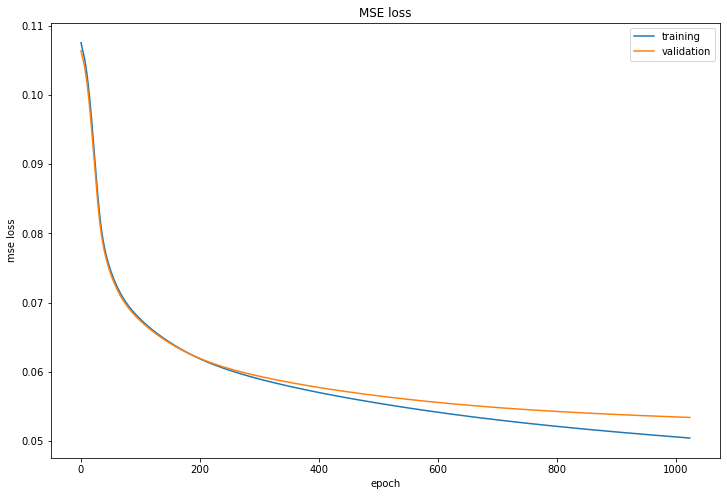

In [17]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.title('MSE loss')

In [29]:
class Analysis:
    def __init__(self):
        self.crop = 100
        self.fsize = 6
        self.histogram_bins = 40
        
    def wrap_phi(self, var):
        var = var%(2*np.pi)
        var = var - 2*np.pi*(var > np.pi)
        return var
        
    def predictions_vs_sample(self, compare, true, names, wrap_phi):
        plt.figure(figsize=(self.fsize*2, self.fsize*len(names)))
        for i in range(0, len(names)):
            compare_small = compare[:self.crop,i]
            true_small = true[:self.crop,i]
            if wrap_phi and "phi" in names[i]:
                compare_small = self.wrap_phi(compare_small)
                true_small = self.wrap_phi(true_small)
            plt.subplot(len(names), 1, i+1)
            plt.plot(range(0,self.crop), compare_small, 'bo', markersize=3, label = 'Predictions')
            plt.plot(range(0,self.crop), true_small, 'ro', markersize=3, label = 'True Value')
            ym, yM = plt.ylim()
            for x in range(self.crop):
                plt.vlines(x, color='g', linestyle='-', alpha=0.2, ymin= 
                            min(compare_small[x], true_small[x]), 
                            ymax= max(compare_small[x], true_small[x]))
            plt.hlines(np.mean(true[:,i]), xmin=-20, xmax=crop+20, alpha=0.5)
            MSE = 1/compare[:,i].size*np.sum((compare[:,i]- true[:,i])**2)
            plt.xlabel('Sample')
            plt.xlim(0, self.crop)
            plt.ylabel(names[i])
            plt.title(names[i] + " MSE: " + str(MSE))
            plt.legend()
    
    def display_errors(self, compare, true, names, wrap_phi):
        MSE = 1/compare.size*np.sum((compare- true)**2)
        print("total MSE: " + str(MSE))
        print(" ")
        for i in range(len(names)):
            diff = compare[:,i] -true[:,i]
            if wrap_phi and "phi" in names[i]:
                diff = self.wrap_phi(diff)
            MSE = 1/compare[:,i].size*np.sum((diff)**2)
            print("{0} MSE : ".format(names[i]), '%.10f'%MSE)
    
    def difference_histogram(self, compare, true, names, wrap_phi):
        plt.figure(figsize=(self.fsize*2,self.fsize*len(names)))
        for i in range(len(names)):
            plt.subplot(len(names), 1, i+1)
            diff = true[:,i] - compare[:,i]
            if wrap_phi and "phi" in names[i]:
                diff = self.wrap_phi(diff)
            hist0, bin_edges = np.histogram(true[:, i], bins=self.histogram_bins)
            plt.hist(diff, bin_edges, histtype='step', color='purple', label='true - predicted', density=True)
            plt.xlabel("Difference (Mean: {0}, Std: {1})".format(np.mean(diff), np.std(diff)))
            plt.title(names[i])
            plt.legend()
            plt.ylabel('Frequency')
            
    def variable_histogram(self, compare, true, names, wrap_phi): 
        plt.figure(figsize=(self.fsize*2,self.fsize*len(names)))
        for i in range(len(names)):
            plt.subplot(len(names), 1, i+1)
            compare_small = compare[:, i]
            true_small = true[:, i]
            if wrap_phi and "phi" in names[i]:
                compare_small = self.wrap_phi(compare_small)
                true_small = self.wrap_phi(true_small)
            hist, edges = np.histogram(true_small, self.histogram_bins)
            plt.hist(true_small, edges, histtype='step', color='b', label='true values', density=True)
            plt.hist(compare_small, edges, histtype='step', color='r', label='predictions', density=True)
            plt.xlabel(names[i])
            plt.title(names[i])
            plt.legend()
            plt.ylabel('Frequency')
    
    def difference_vs_variable(self, compare, true, names, wrap_phi):
        plt.figure(figsize=(self.fsize*2,self.fsize*len(names)))
        for i in range(len(names)):
            plt.subplot(len(names), 1, i+1)
            plt.plot(true[:, i], true[:, i]-compare[:, i], 'o', color='purple', label='True - Predicted', markersize=2)
            plt.xlabel('True ' + names[i])
            plt.legend()
            plt.ylabel('Difference')

In [36]:

display = Analysis()

predictions_unscaled = model.predict([testX])
true_unscaled = testY 

total_predictions = model.predict([np.append(trainX,testX,axis=0)])
(Y_total, TO_maxmean0), _ = Scaler.scale_arrays(Y_keys, Y_methods, True)

predictions_origscale = Scaler.invscale_arrays(Y_keys, total_predictions, _, Y_methods, TO_maxmean0)[split:,:]
true_origscale = Scaler.invscale_arrays(Y_keys, Y_total, _, Y_methods, TO_maxmean0)[split:,:]

del Y_total
del TO_maxmean0
del _
del total_predictions

# Training scale plots 

In [37]:
display.display_errors(predictions_unscaled, true_unscaled, Y_names, False)

total MSE: 0.04838268818443875
 
th_pt MSE :  0.0270471655
th_eta MSE :  0.0128814612
th_phi-sin MSE :  0.1678587012
th_phi-cos MSE :  0.0745081095
tl_pt MSE :  0.0203895029
tl_eta MSE :  0.0108505871
tl_phi-sin MSE :  0.1238835209
tl_phi-cos MSE :  0.0451071514
wl_eta MSE :  0.0096398067
wl_phi-sin MSE :  0.0604228730
wl_phi-cos MSE :  0.0139877297
wl_pt MSE :  0.0140156492


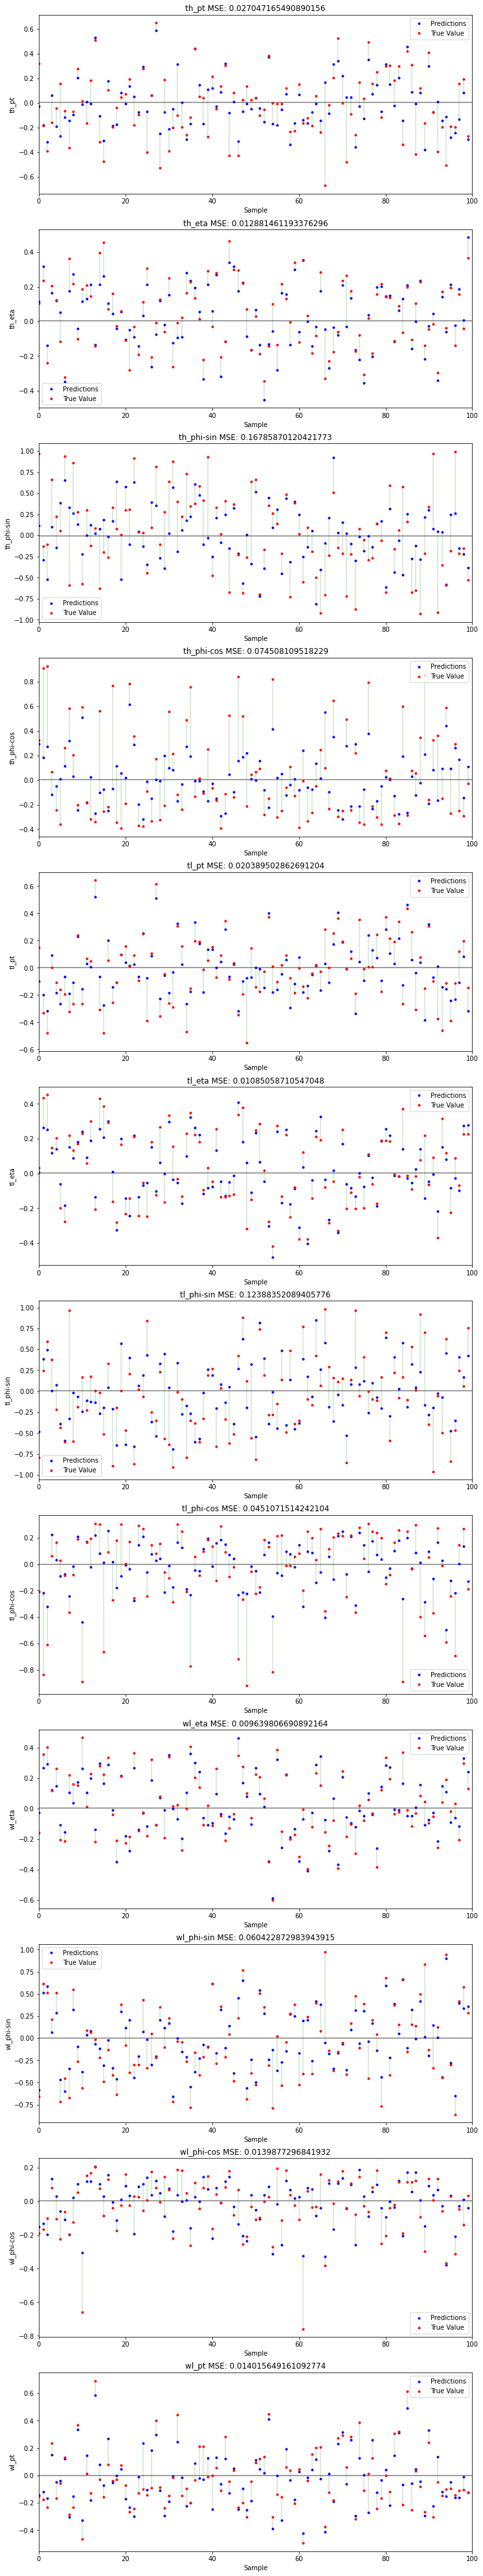

In [38]:
display.predictions_vs_sample(predictions_unscaled, true_unscaled, Y_names, False)

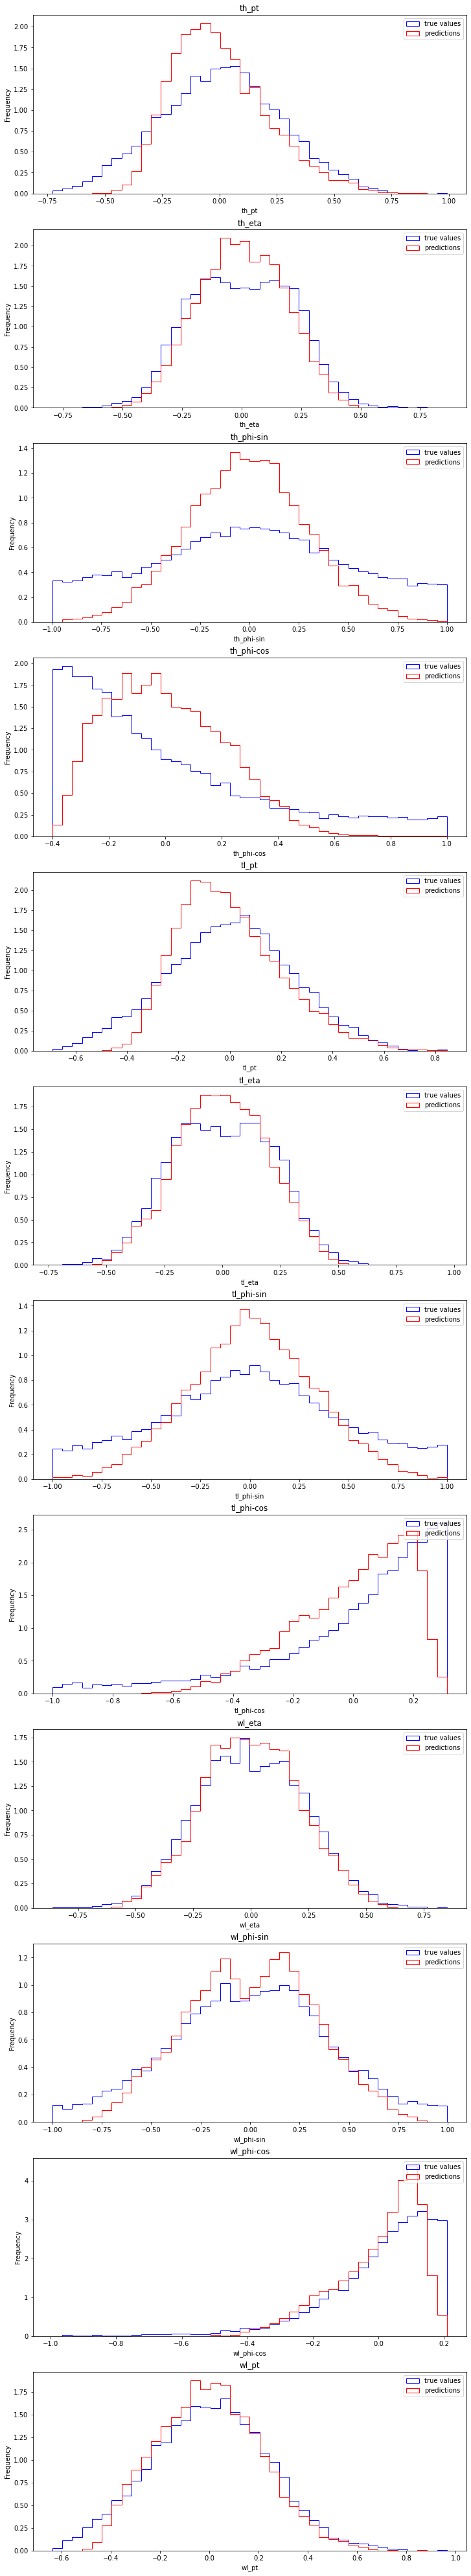

In [39]:
display.variable_histogram(predictions_unscaled, true_unscaled, Y_names, False)

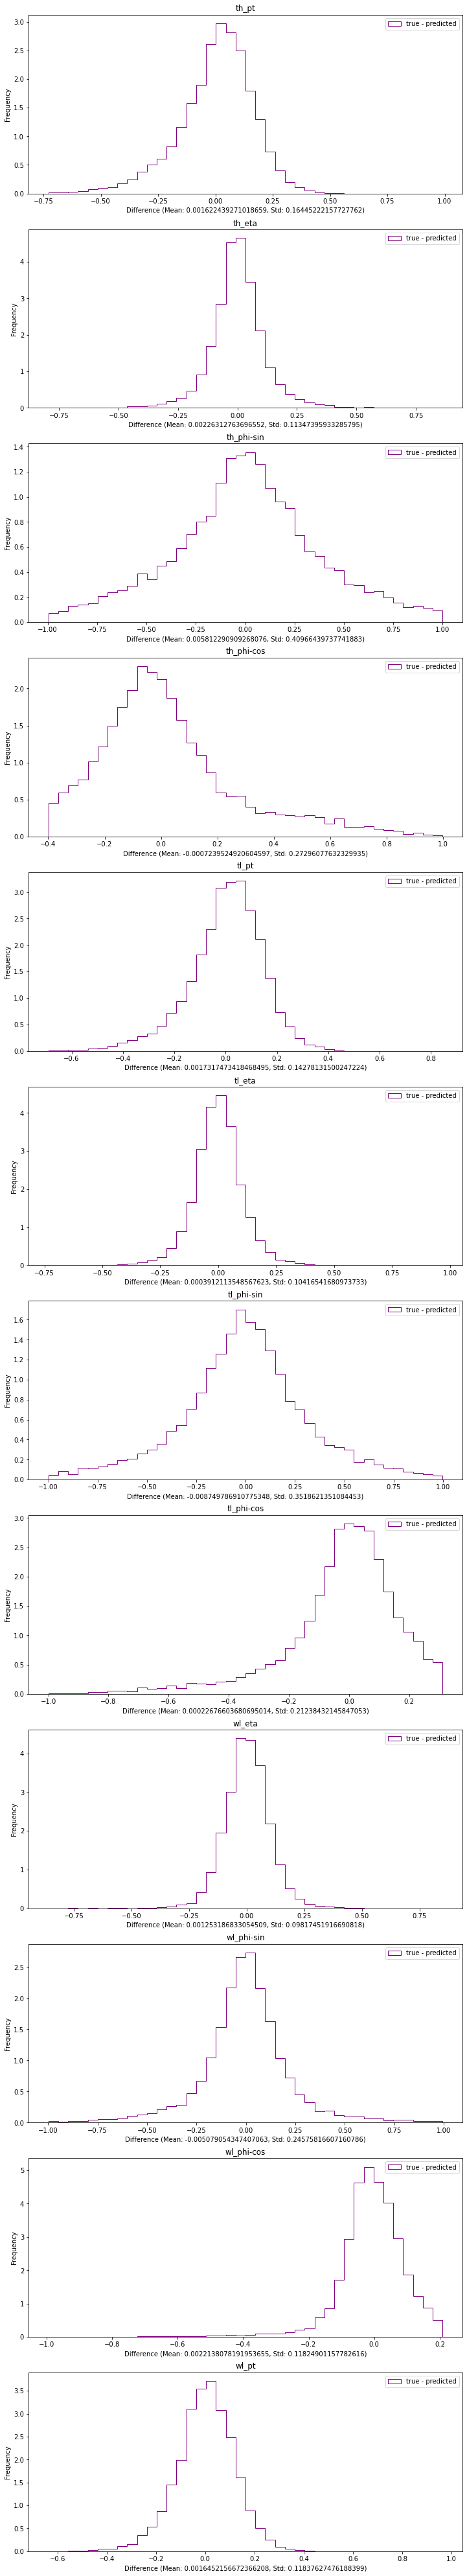

In [40]:
display.difference_histogram(predictions_unscaled, true_unscaled, Y_names, False)

 # Original scale plots

In [41]:
display.display_errors(predictions_origscale, true_origscale, Y_keys, True)

total MSE: 467.44661052819833
 
th_pt MSE :  1862.6158061471
th_eta MSE :  0.7086074784
th_phi MSE :  0.9031444781
tl_pt MSE :  1560.6333386201
tl_eta MSE :  0.5429756549
tl_phi MSE :  0.5937032422
wl_eta MSE :  0.3444969184
wl_phi MSE :  0.2207763703
wl_pt MSE :  774.7953800653


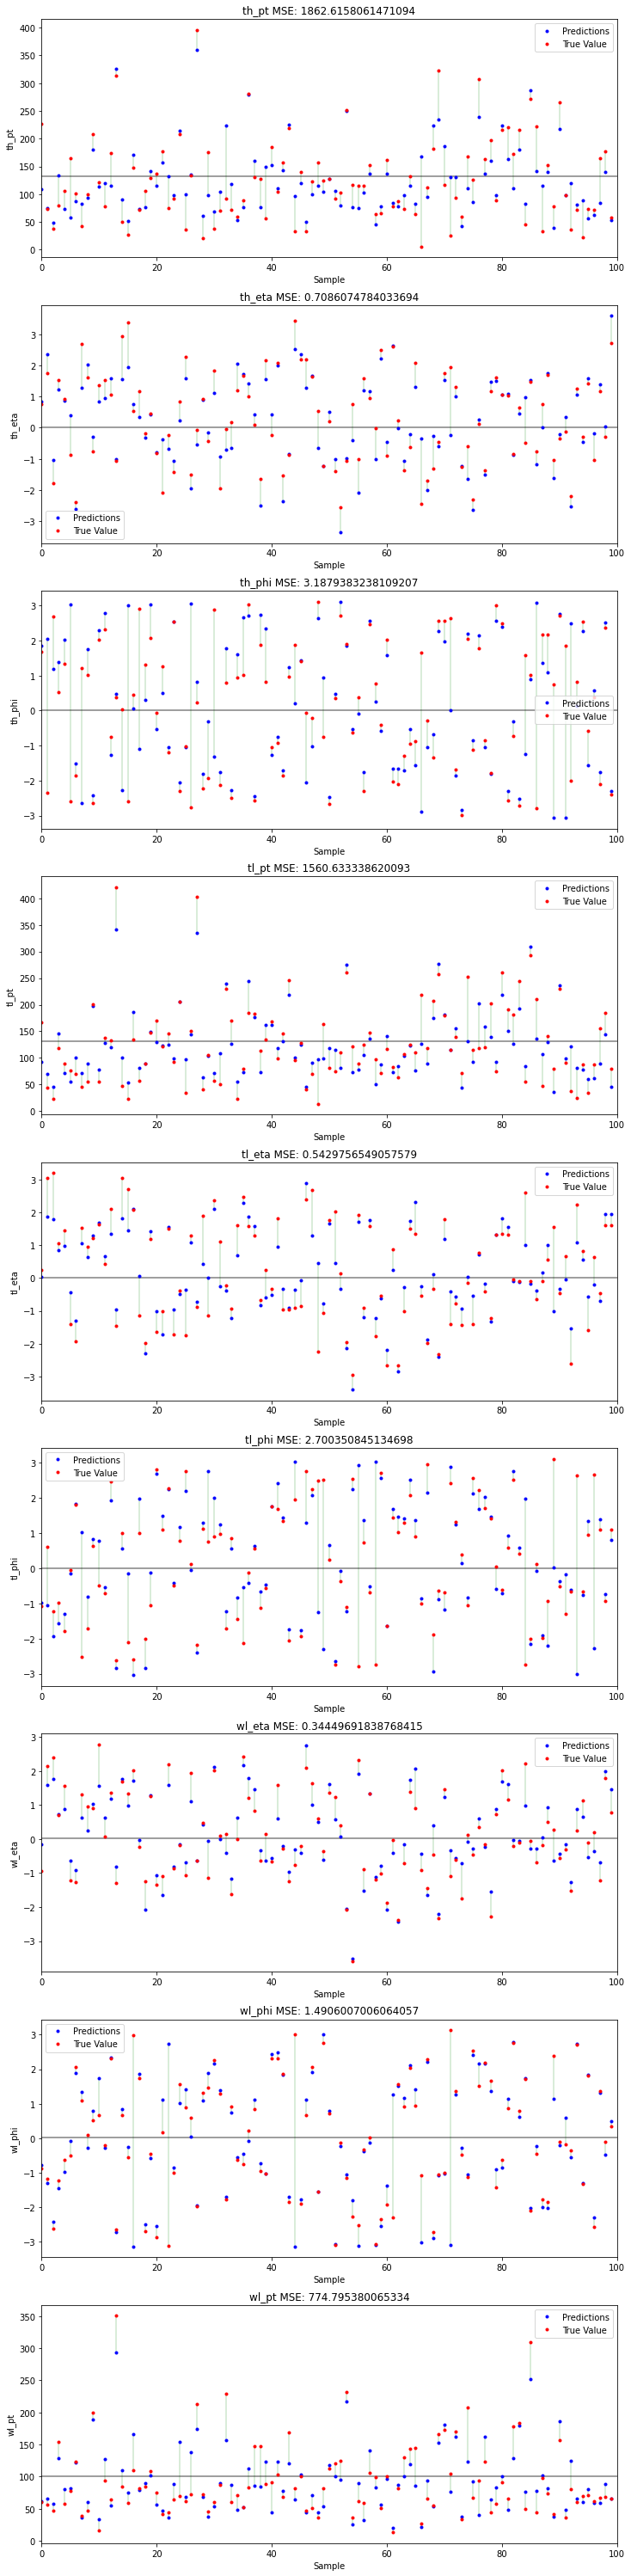

In [42]:
display.predictions_vs_sample(predictions_origscale, true_origscale, Y_keys, True)

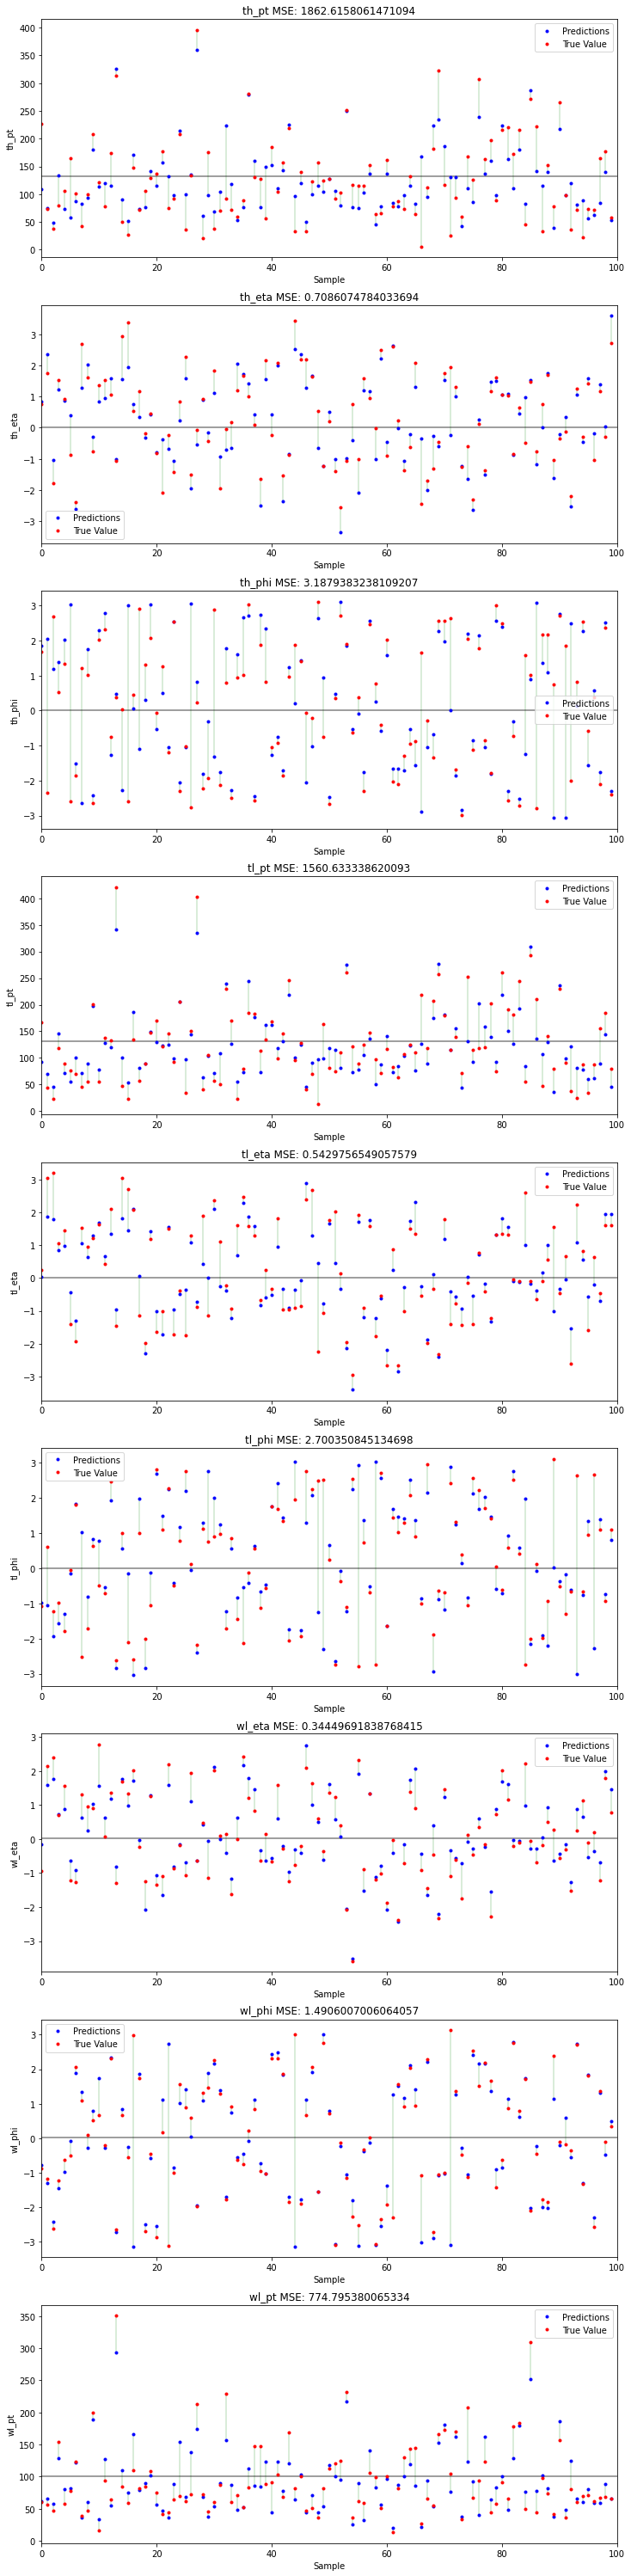

In [43]:
display.predictions_vs_sample(predictions_origscale, true_origscale, Y_keys, True)

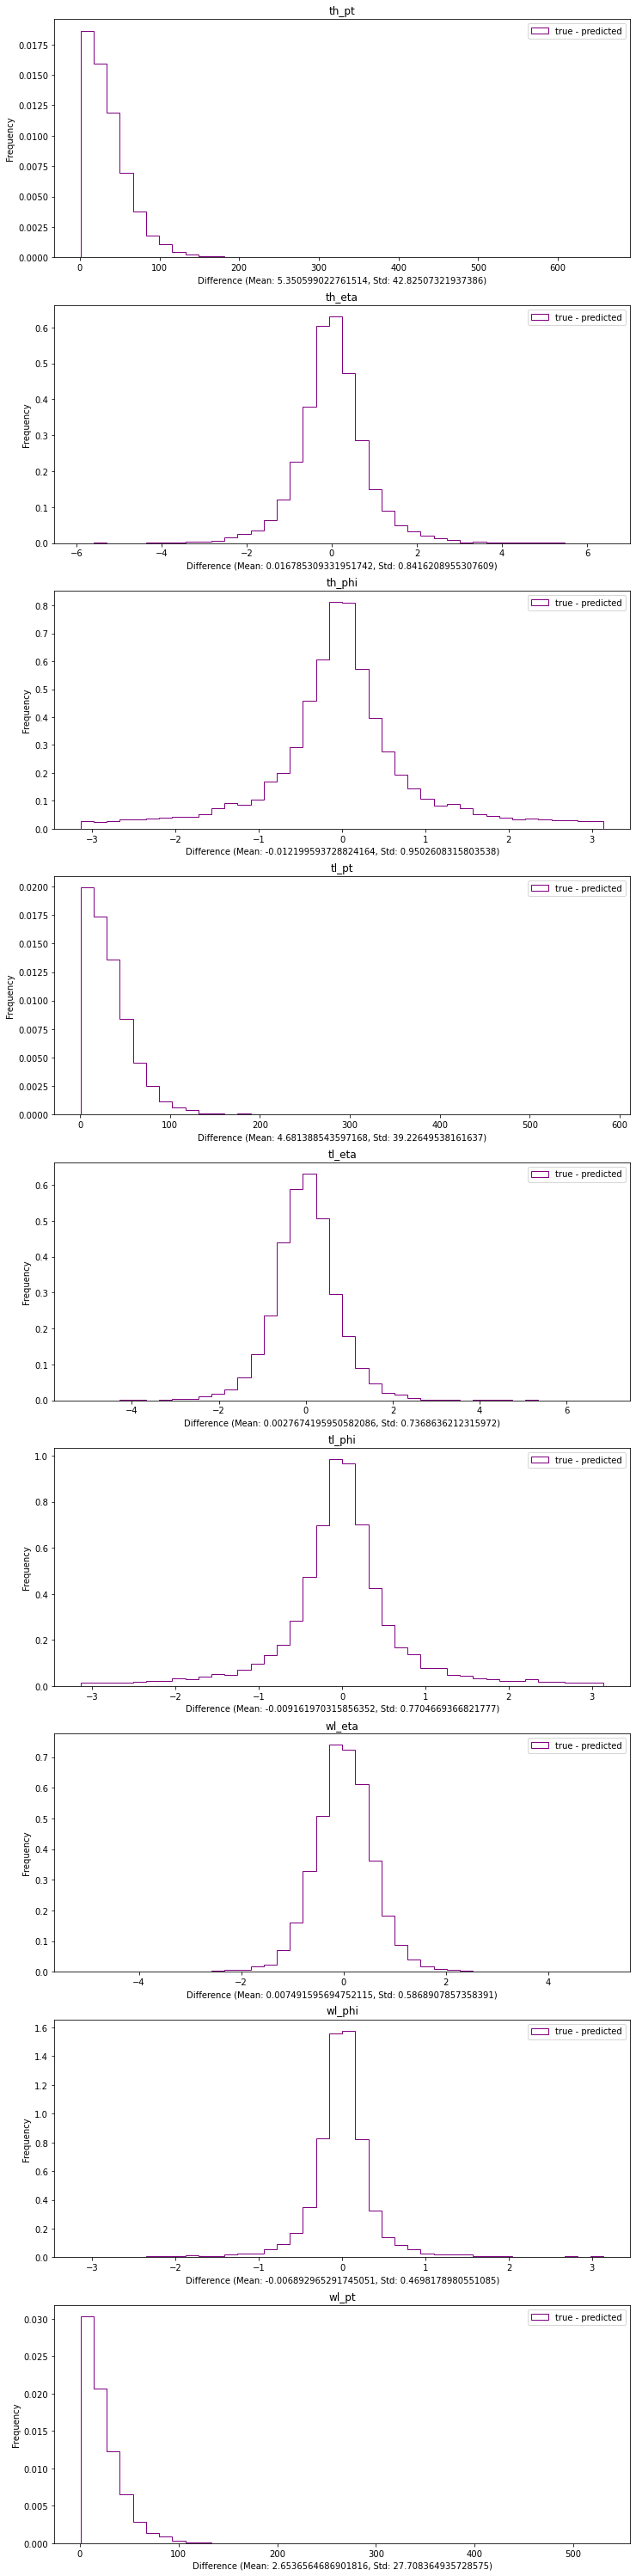

In [44]:
display.difference_histogram(predictions_origscale, true_origscale, Y_keys, True)

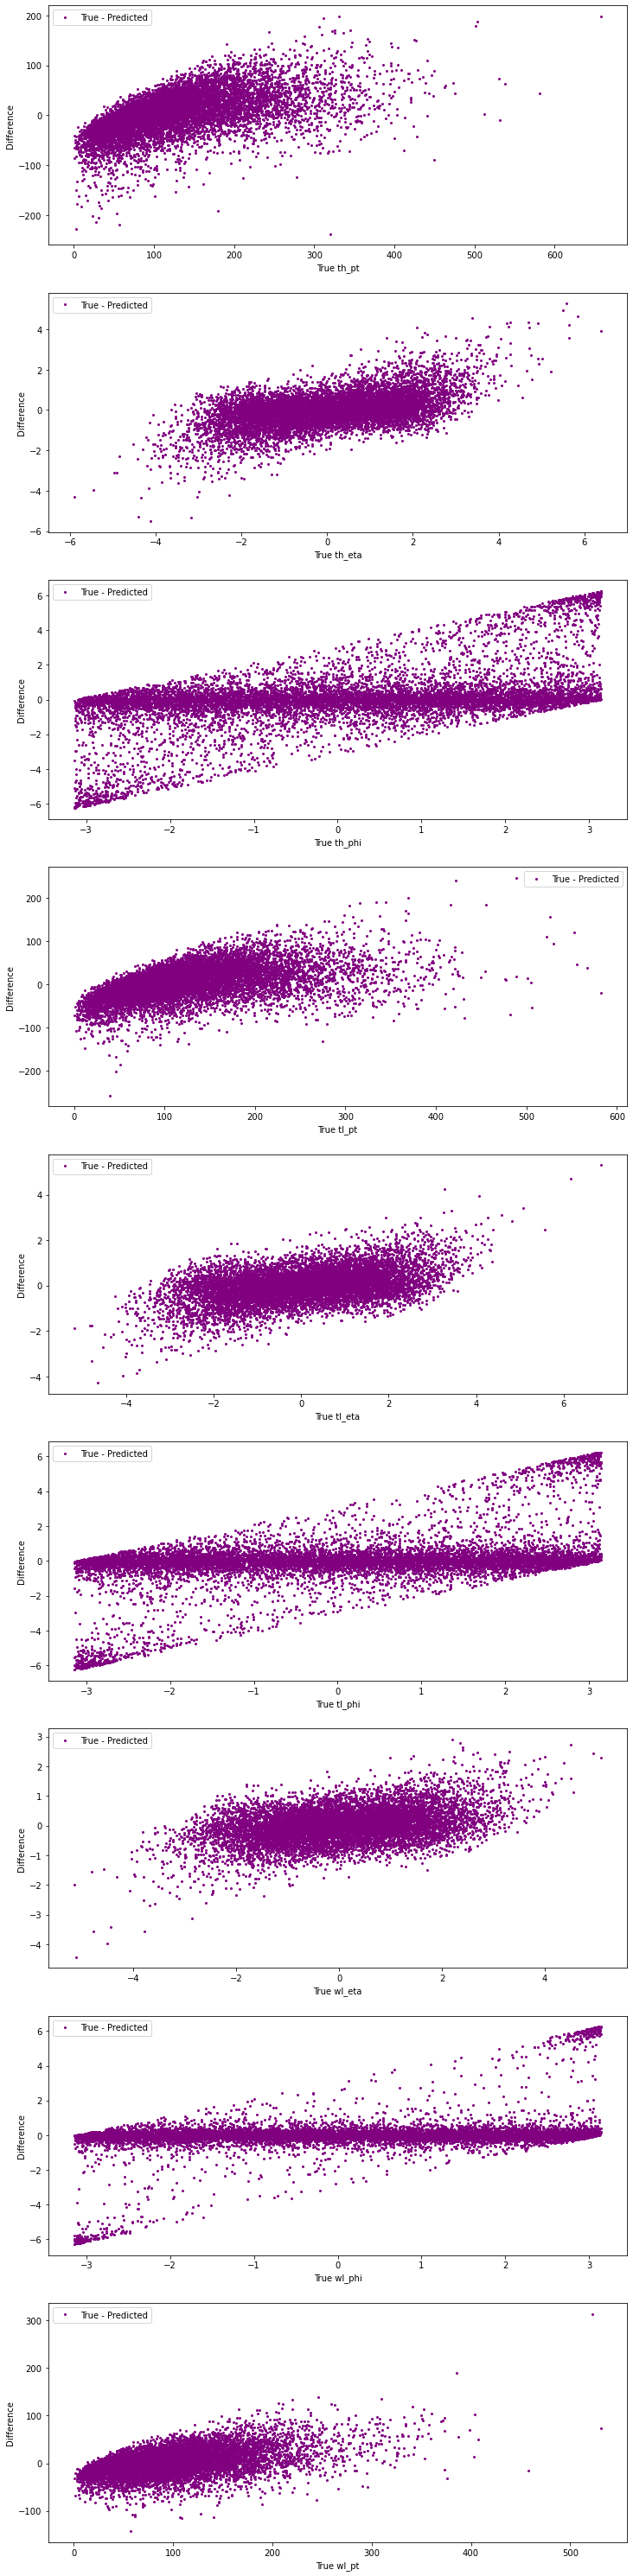

In [45]:
display.difference_vs_variable(predictions_origscale, true_origscale, Y_keys, True)